Jasper Wilson
6/13/2022
Hearthstone Card Analysis

This is a small data-science project to demonstrate my abilities with common tools and processes. The aims of this project are to:
<ol>
    <li> Create a dataframe that includes all Hearthstone Cardss and a value that we can associate with their strength</li>
    <li> Use https://rapidapi.com/omgvamp/api/hearthstone/ to get the full information from each card </li>
    <li> Create and normalize dataframe that includes baisic features that could be relevant to a card's strength </li>
    <li> Use ML tools to make a function that can predict the strength of hypothetical cards </li>
</ol>
This project is unlikely to weild impactful results, since the strength of cards is tied to complex factors like card-specific text that will not be evaluated in this project. The goal of this project is to show my proficiency with data science tools. Hypothetically, a text-analysis may be able to improve my results but the sample size is likely not large enough for this approach to be effective.

Lets start by importing some necessary libraries for this project.

In [1]:
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

import time
import math
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2022-06-24 12:43:00.349450: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-24 12:43:00.349490: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


The best source for information on the strength of individual cards is https://hsreplay.net/cards/#sortBy=includedPopularity&gameType=RANKED_WILD&showSparse=yes. So let's try scraping the information from this website.

In [2]:
page = requests.get("https://hsreplay.net/cards/#sortBy=includedPopularity&gameType=RANKED_WILD&showSparse=yes&type=MINION").text
soup = BeautifulSoup(page, 'html.parser')

Now that we have our page let's use soup to get a list of all the card names and check to make sure that is has all the cards.

In [3]:
card_names = soup.find_all(class_='card-tile')
print(len(card_names))

0


Well that isn't right. It seems like this page loads the cards with JavaScript, so we need to use Selenium to load the page before we scrape it. 

In [4]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get('https://hsreplay.net/cards/#sortBy=includedPopularity&gameType=RANKED_WILD&showSparse=yes&type=MINION')

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - About to download new driver from https://chromedriver.storage.googleapis.com/102.0.5005.61/chromedriver_linux64.zip
[WDM] - Driver has been saved in cache [/home/jaspermwilson/.wdm/drivers/chromedriver/linux64/102.0.5005.61]


WebDriverException: Message: unknown error: Chrome failed to start: exited abnormally.
  (unknown error: DevToolsActivePort file doesn't exist)
  (The process started from chrome location /usr/bin/google-chrome is no longer running, so ChromeDriver is assuming that Chrome has crashed.)
Stacktrace:
#0 0x55c9c7cf3f33 <unknown>
#1 0x55c9c7a3e118 <unknown>
#2 0x55c9c7a61678 <unknown>
#3 0x55c9c7a5cd5a <unknown>
#4 0x55c9c7a97d3a <unknown>
#5 0x55c9c7a91e63 <unknown>
#6 0x55c9c7a6782a <unknown>
#7 0x55c9c7a68985 <unknown>
#8 0x55c9c7d384cd <unknown>
#9 0x55c9c7d3c5ec <unknown>
#10 0x55c9c7d2271e <unknown>
#11 0x55c9c7d3d238 <unknown>
#12 0x55c9c7d17870 <unknown>
#13 0x55c9c7d59608 <unknown>
#14 0x55c9c7d59788 <unknown>
#15 0x55c9c7d73f1d <unknown>
#16 0x7f176f66b609 <unknown>


That didn't work for me, so let's use the solution from https://stackoverflow.com/questions/53073411/selenium-webdriverexceptionchrome-failed-to-start-crashed-as-google-chrome-is. If the previous block didn't throw an error for you skip the next step.

In [ ]:
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

driver = webdriver.Chrome('/home/jaspermwilson/hs_deck_completion/chromedriver',chrome_options=chrome_options) #replace path here with path to chromedriver, see full details at https://chromedriver.chromium.org/getting-started
driver.get('https://hsreplay.net/cards/#sortBy=includedPopularity&gameType=RANKED_WILD&showSparse=yes&type=MINION')

Alright now that we can read the JavaScript let's see how many cards we have now.

In [ ]:
html = driver.page_source
soup = BeautifulSoup(html)
card_names = soup.find_all(class_='card-tile')
print(len(card_names))

That still isn't right. There should be well over 1000 cards on this page. Unfortunately these cards are loaded dynamically after the user scrolls. So let's take a solution from https://stackoverflow.com/questions/20986631/how-can-i-scroll-a-web-page-using-selenium-webdriver-in-python to load all the cards. This code is inconsistent, loading the page may take a variable amount of time or hsreplay.net could refuse connection. Trying different pause times I was able to get all the cards and saved the output from later functions into text files.

In [ ]:
SCROLL_PAUSE_TIME = 2

# Get scroll height
last_height = driver.execute_script("return document.body.scrollHeight")

#scroll down
driver.execute_script("window.scrollTo(0, 1000);")

while True:
    # Scroll down to bottom
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # Wait to load page
    time.sleep(SCROLL_PAUSE_TIME)

    # Calculate new scroll height and compare with last scroll height
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

In [ ]:
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

In [ ]:
driver.execute_script("window.scrollTo(0, 1000);")

The following code blocks were used to generate the text-files to use for later use on 6/12/2022. If you want to generate new data un-comment this code, otherwise skip the next block.


In [ ]:
html = driver.page_source
soup = BeautifulSoup(html)

card_names_soup = soup.find_all(class_='card-tile')
card_names_list = []
for i in card_names_soup:
    card_names_list.append(i['aria-label'])

with open('Card_Names.txt', 'w') as f:
    for line in card_names_list:
        f.write(line)
        f.write('\n')
    
statistics = soup.find_all('div', {'aria-describedby':re.compile('table1-row\S+ table1-column0')})
played_percent_list = []
for i in statistics:
    played_percent_list.append(i.text)

with open('Card_Played_Rate.txt', 'w') as f:
    for line in played_percent_list:
        f.write(line)
        f.write('\n')

Get data from our text files, and make sure that the length and content looks right.

In [5]:
card_names_file = open("Card_Names.txt", "r")
card_names_data = card_names_file.read()
card_names_list = card_names_data.split("\n")
print(len(card_names_list))
print(card_names_list[0])

played_percent_file = open("Card_Played_Rate.txt", "r")
played_percent_data = played_percent_file.read()
played_percent_list = played_percent_data.split("\n")
print(len(played_percent_list))
print(played_percent_list[0])

2535
Zephrys the Great
2535
13.0%


These are one card too long since the last split returns an empty line, so we need to remove the last value from each list.

In [6]:
card_names_list.pop()
played_percent_list.pop()


''

Now let's make our dataframe.

In [7]:
df = pd.DataFrame()
df['Name'] = card_names_list
df['Inclusion Rate String'] = played_percent_list
df


,Name,Inclusion Rate String
0,Zephrys the Great,13.0%
1,Mutanus the Devourer,12.8%
2,Dirty Rat,10.9%
3,Brann Bronzebeard,10.6%
4,Blademaster Okani,9.6%
...,...,...
2529,Am'gam Rager,0%
2530,Air Elemental,0%
2531,Acidmaw,0%
2532,Abominable Bowman,0%


The inclusion rate is still a string, so I will convert it into a float and drop the string column.

In [8]:
df['Inclusion Rate'] = df['Inclusion Rate String'].str.rstrip('%').astype('float') / 100.0
df.drop('Inclusion Rate String', axis=1, inplace = True)
df

,Name,Inclusion Rate
0,Zephrys the Great,0.130
1,Mutanus the Devourer,0.128
2,Dirty Rat,0.109
3,Brann Bronzebeard,0.106
4,Blademaster Okani,0.096
...,...,...
2529,Am'gam Rager,0.000
2530,Air Elemental,0.000
2531,Acidmaw,0.000
2532,Abominable Bowman,0.000


Now we need to get the rest of our relevant information. First attempt was to iterate through the dataframe and get the information, but this takes too long with the 1000+ api requests.

In [9]:
# def getCardType(card_name):
#     print(card_name)
#     formatted_name = card_name.replace(' ', '%20')
#     url = f"https://omgvamp-hearthstone-v1.p.rapidapi.com/cards/{formatted_name}"
    
#     querystring = {"collectible":"1"}

#     headers = {
#         "X-RapidAPI-Key": "64accc3c01msh8386ed44b3b00b7p1766a1jsna7ddde737a91",
#         "X-RapidAPI-Host": "omgvamp-hearthstone-v1.p.rapidapi.com"
#     }

#     response = requests.request("GET", url, headers=headers, params=querystring).json()

#     #should return a list of length 1
#     return(response[0]['type'])

# df['type_label'] = df.apply (lambda row: getCardType(row['Name']), axis=1)

Instead let's just get all the cards and work with the data locally.

In [10]:
url = "https://omgvamp-hearthstone-v1.p.rapidapi.com/cards"

querystring = {"collectible":"1"}

headers = {
    "X-RapidAPI-Key": "64accc3c01msh8386ed44b3b00b7p1766a1jsna7ddde737a91",
    "X-RapidAPI-Host": "omgvamp-hearthstone-v1.p.rapidapi.com"
}

response = requests.request("GET", url, headers=headers, params=querystring).json()


Now we have a complex json object that contains all the cards and their information, lets select all the sets we are interested in and combine them into one large dataframe. We can't use all sets because some outdated collections of cards would have old versions of cards that have since been changed.

In [11]:
listOfSets = ['Core', 'Goblins vs Gnomes', 'The Grand Tournament', 'Whispers of the Old Gods', 'Mean Streets of Gadgetzan', 'Journey to Un\'Goro', 'Knights of the Frozen Throne', 'Kobolds & Catacombs', 'The Witchwood', 'The Boomsday Project', 'Rastakhan\'s Rumble', 'Rise of Shadows', 'Saviors of Uldum', 'Descent of Dragons', 'Ashes of Outland', 'Scholomance Academy', 'Forged in the Barrens', 'United in Stormwind', 'Fractured in Alterac Valley', 'Voyage to the Sunken City']
allCardsDF = pd.DataFrame()
for set in listOfSets:
    newDF = pd.DataFrame(response[set])
    allCardsDF = pd.concat([allCardsDF,newDF],ignore_index=True)
allCardsDF

,cardId,dbfId,name,cardSet,type,faction,rarity,cost,text,flavor,...,health,race,mechanics,durability,elite,armor,imgGold,multiClassGroup,classes,howToGetDiamond
0,CORE_CS2_072,69521,Backstab,Core,Spell,Neutral,Common,0,Deal $2 damage to an undamaged minion.,"It's funny how often yelling ""Look over there!...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CORE_EX1_169,69550,Innervate,Core,Spell,Neutral,Rare,0,Gain 1 Mana Crystal this turn only.,Some druids still have flashbacks from strange...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CORE_LOEA10_3,69723,Murloc Tinyfin,Core,Minion,NaN,Common,0,NaN,"High mortality rate, from often being hugged t...",...,1.0,Murloc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CORE_TRL_243,69689,Pounce,Core,Spell,NaN,Common,0,Give your hero +2_Attack this turn.,Comes with an overwhelming urge to jump into t...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CORE_EX1_145,69623,Preparation,Core,Spell,Neutral,Epic,0,The next spell you cast this turn costs (2) less.,"""Be Prepared"" - Rogue Motto",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932,TID_077,76258,Lightray,Voyage to the Sunken City,Minion,NaN,Common,9,<b>Taunt</b>\nCosts (1) less for each Paladin ...,"Lightrays, much like rays of light, tend to be...",...,5.0,Elemental,[{'name': 'Taunt'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN
2933,TSC_659,74672,Trenchstalker,Voyage to the Sunken City,Minion,NaN,Epic,9,<b>Battlecry:</b> Attack three different rando...,Cooler heads prevail.,...,9.0,Beast,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN
2934,TID_712,75583,Neptulon the Tidehunter,Voyage to the Sunken City,Minion,NaN,Legendary,10,"[x]<b>Colossal +2</b>, <b>Rush</b>, <b>Windfur...","Neptulon, tired of filling hands, is now throw...",...,7.0,Elemental,"[{'name': 'Rush'}, {'name': 'Windfury'}, {'nam...",NaN,True,NaN,NaN,NaN,NaN,NaN
2935,TSC_061,73434,The Garden's Grace,Voyage to the Sunken City,Spell,NaN,Epic,10,[x]Give a minion +5/+5 and\n<b>Divine Shield</...,The perfect place to hold Conchella.,...,NaN,NaN,[{'name': 'Divine Shield'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looking at this table we can see a lot of NaNs. This is because different types of cards have different traits. All minions have attack and health, but no spells do. Instead of dropping NaNs or some of these features let's focus our analysis on only minions.

In [12]:
allMinionsDF = allCardsDF[allCardsDF['type'] == 'Minion']
allMinionsDF

,cardId,dbfId,name,cardSet,type,faction,rarity,cost,text,flavor,...,health,race,mechanics,durability,elite,armor,imgGold,multiClassGroup,classes,howToGetDiamond
2,CORE_LOEA10_3,69723,Murloc Tinyfin,Core,Minion,NaN,Common,0,NaN,"High mortality rate, from often being hugged t...",...,1.0,Murloc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,CORE_CS2_188,69649,Abusive Sergeant,Core,Minion,Alliance,Common,1,<b>Battlecry:</b> Give a minion +2_Attack this...,"ADD ME TO YOUR DECK, MAGGOT!",...,1.0,NaN,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,CORE_KAR_009,69700,Babbling Book,Core,Minion,NaN,Rare,1,<b>Battlecry:</b> Add a random Mage spell to y...,"His idol is the Green Hills of Stranglethorn, ...",...,1.0,NaN,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,CORE_BT_351,69586,Battlefiend,Core,Minion,NaN,Common,1,"After your hero attacks, gain +1 Attack.",Say what you like about my hatchet-headed hool...,...,2.0,Demon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,CORE_ULD_191,76318,Beaming Sidekick,Core,Minion,NaN,Common,1,<b>Battlecry:</b> Give a friendly minion +2 He...,"Sure, I'll carry the water! And the food! And ...",...,2.0,NaN,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2929,TID_716,75635,Tidal Revenant,Voyage to the Sunken City,Minion,NaN,Common,8,<b>Battlecry:</b> Deal 5 damage. Gain 5 Armor.,A big minion that clears the board and gains A...,...,8.0,Elemental,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN
2932,TID_077,76258,Lightray,Voyage to the Sunken City,Minion,NaN,Common,9,<b>Taunt</b>\nCosts (1) less for each Paladin ...,"Lightrays, much like rays of light, tend to be...",...,5.0,Elemental,[{'name': 'Taunt'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN
2933,TSC_659,74672,Trenchstalker,Voyage to the Sunken City,Minion,NaN,Epic,9,<b>Battlecry:</b> Attack three different rando...,Cooler heads prevail.,...,9.0,Beast,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN
2934,TID_712,75583,Neptulon the Tidehunter,Voyage to the Sunken City,Minion,NaN,Legendary,10,"[x]<b>Colossal +2</b>, <b>Rush</b>, <b>Windfur...","Neptulon, tired of filling hands, is now throw...",...,7.0,Elemental,"[{'name': 'Rush'}, {'name': 'Windfury'}, {'nam...",NaN,True,NaN,NaN,NaN,NaN,NaN


Now we can do an inner join with our two dataframes to get our list of minions with a full set of features.


In [13]:
joinedDF = pd.merge(allMinionsDF, df, left_on='name', right_on='Name')
joinedDF

,cardId,dbfId,name,cardSet,type,faction,rarity,cost,text,flavor,...,mechanics,durability,elite,armor,imgGold,multiClassGroup,classes,howToGetDiamond,Name,Inclusion Rate
0,CORE_LOEA10_3,69723,Murloc Tinyfin,Core,Minion,NaN,Common,0,NaN,"High mortality rate, from often being hugged t...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Murloc Tinyfin,0.0090
1,CORE_LOEA10_3,69723,Murloc Tinyfin,Core,Minion,NaN,Common,0,NaN,"High mortality rate, from often being hugged t...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Murloc Tinyfin,0.0004
2,CORE_CS2_188,69649,Abusive Sergeant,Core,Minion,Alliance,Common,1,<b>Battlecry:</b> Give a minion +2_Attack this...,"ADD ME TO YOUR DECK, MAGGOT!",...,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abusive Sergeant,0.0030
3,CORE_CS2_188,69649,Abusive Sergeant,Core,Minion,Alliance,Common,1,<b>Battlecry:</b> Give a minion +2_Attack this...,"ADD ME TO YOUR DECK, MAGGOT!",...,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abusive Sergeant,0.0007
4,CORE_KAR_009,69700,Babbling Book,Core,Minion,NaN,Rare,1,<b>Battlecry:</b> Add a random Mage spell to y...,"His idol is the Green Hills of Stranglethorn, ...",...,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Babbling Book,0.0090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178,TID_716,75635,Tidal Revenant,Voyage to the Sunken City,Minion,NaN,Common,8,<b>Battlecry:</b> Deal 5 damage. Gain 5 Armor.,A big minion that clears the board and gains A...,...,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tidal Revenant,0.0020
2179,TID_077,76258,Lightray,Voyage to the Sunken City,Minion,NaN,Common,9,<b>Taunt</b>\nCosts (1) less for each Paladin ...,"Lightrays, much like rays of light, tend to be...",...,[{'name': 'Taunt'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lightray,0.0030
2180,TSC_659,74672,Trenchstalker,Voyage to the Sunken City,Minion,NaN,Epic,9,<b>Battlecry:</b> Attack three different rando...,Cooler heads prevail.,...,[{'name': 'Battlecry'}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,Trenchstalker,0.0008
2181,TID_712,75583,Neptulon the Tidehunter,Voyage to the Sunken City,Minion,NaN,Legendary,10,"[x]<b>Colossal +2</b>, <b>Rush</b>, <b>Windfur...","Neptulon, tired of filling hands, is now throw...",...,"[{'name': 'Rush'}, {'name': 'Windfury'}, {'nam...",NaN,True,NaN,NaN,NaN,NaN,NaN,Neptulon the Tidehunter,0.0330


Alright we have a lot of features here so let's drop anything that seems irrelevant. This is the kind of decision that requries domain knowledge.

In [14]:
joinedDF.drop(['name', 'cardId', 'dbfId', 'cardSet', 'type', 'faction', 'text', 'flavor', 'artist', 'collectible',
       'howToGet', 'howToGetGold', 'img', 'locale', 'spellSchool', 'classes',
        'durability', 'elite', 'armor',
       'imgGold', 'multiClassGroup', 'howToGetDiamond', 'Name',], axis=1, inplace=True)

In our group of remaining features we have 'mechanics' which is relevant, but is unfortunately a list of dictionaries because of how we interpreted our json response. We can fix this with a quick function that we can apply to our dataframe and convert each list of dictionaries into a list of items.

In [15]:
def convertDictsToList (row):
    newList = []
    if(isinstance(row['mechanics'], float)):
        return []
    for item in row['mechanics']:
        newList.append(item.get('name'))  
    return newList

joinedDF['mechanics_list'] = joinedDF.apply (lambda row: convertDictsToList(row), axis=1)
joinedDF

,rarity,cost,playerClass,attack,health,race,mechanics,Inclusion Rate,mechanics_list
0,Common,0,Neutral,1.0,1.0,Murloc,NaN,0.0090,[]
1,Common,0,Neutral,1.0,1.0,Murloc,NaN,0.0004,[]
2,Common,1,Neutral,1.0,1.0,NaN,[{'name': 'Battlecry'}],0.0030,[Battlecry]
3,Common,1,Neutral,1.0,1.0,NaN,[{'name': 'Battlecry'}],0.0007,[Battlecry]
4,Rare,1,Mage,1.0,1.0,NaN,[{'name': 'Battlecry'}],0.0090,[Battlecry]
...,...,...,...,...,...,...,...,...,...
2178,Common,8,Warrior,5.0,8.0,Elemental,[{'name': 'Battlecry'}],0.0020,[Battlecry]
2179,Common,9,Paladin,5.0,5.0,Elemental,[{'name': 'Taunt'}],0.0030,[Taunt]
2180,Epic,9,Warrior,8.0,9.0,Beast,[{'name': 'Battlecry'}],0.0008,[Battlecry]
2181,Legendary,10,Neutral,7.0,7.0,Elemental,"[{'name': 'Rush'}, {'name': 'Windfury'}, {'nam...",0.0330,"[Rush, Windfury, Colossal +X]"


Now that we have a list of items we can use dummy coding to convert this into several binary features that indicate whether or not a card has a certain mechanic. 

In [16]:
mlb = MultiLabelBinarizer(sparse_output=True)

joinedDF = joinedDF.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(joinedDF.pop('mechanics_list')),
                index=joinedDF.index,
                columns=mlb.classes_))
joinedDF


,rarity,cost,playerClass,attack,health,race,mechanics,Inclusion Rate,Adapt,AdjacentBuff,...,Recruit,Rush,Secret,Silence,Spell Damage,Spellburst,Stealth,Taunt,Tradeable,Windfury
0,Common,0,Neutral,1.0,1.0,Murloc,NaN,0.0090,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Common,0,Neutral,1.0,1.0,Murloc,NaN,0.0004,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Common,1,Neutral,1.0,1.0,NaN,[{'name': 'Battlecry'}],0.0030,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Common,1,Neutral,1.0,1.0,NaN,[{'name': 'Battlecry'}],0.0007,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Rare,1,Mage,1.0,1.0,NaN,[{'name': 'Battlecry'}],0.0090,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178,Common,8,Warrior,5.0,8.0,Elemental,[{'name': 'Battlecry'}],0.0020,0,0,...,0,0,0,0,0,0,0,0,0,0
2179,Common,9,Paladin,5.0,5.0,Elemental,[{'name': 'Taunt'}],0.0030,0,0,...,0,0,0,0,0,0,0,1,0,0
2180,Epic,9,Warrior,8.0,9.0,Beast,[{'name': 'Battlecry'}],0.0008,0,0,...,0,0,0,0,0,0,0,0,0,0
2181,Legendary,10,Neutral,7.0,7.0,Elemental,"[{'name': 'Rush'}, {'name': 'Windfury'}, {'nam...",0.0330,0,0,...,0,1,0,0,0,0,0,0,0,1


Now lets convert the rest of our categorical variables into dummy encodings so that we can use all of our data for a linear regression. We also need to drop the 'mechanics' column since that isn't done automatically.

In [17]:
dummyDf = pd.get_dummies(joinedDF, prefix = ['rarity', 'playerClass', 'race'], columns = ['rarity', 'playerClass', 'race'])
dummyDf.drop(['mechanics'], axis=1, inplace=True)

Now we need to split our data into test and train data, we will use a standard 80-20 split. We also need to seperate our labels for evaluation.

In [18]:
train_data = dummyDf.sample(frac=0.8, random_state=0)
test_data = dummyDf.drop(train_data.index)

train_labels = train_data.pop('Inclusion Rate')
test_labels = test_data.pop('Inclusion Rate')

Now we need to normalize our data, let's use a tensorflow normilization layer.

In [19]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_data))

2022-06-24 12:43:39.964228: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-24 12:43:39.964319: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-24 12:43:39.964344: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-ONVBKQ5): /proc/driver/nvidia/version does not exist
2022-06-24 12:43:39.965660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now we can make and compile our model with the normilization layer and only one other layer to start with.

In [20]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_absolute_error')

Now we can fit our model.

In [21]:
%%time
history = linear_model.fit(
    train_data,
    train_labels,
    epochs=50,
    verbose=0,
    validation_split = 0.2)

CPU times: user 12.2 s, sys: 3.05 s, total: 15.3 s
Wall time: 7.45 s


To view how much our model improves over iterations we can use plotly along with history.

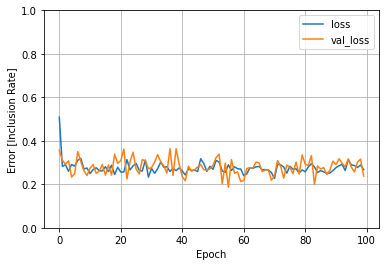

In [22]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Inclusion Rate]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

This looks bad, there is some decrease in error but it is still high at the end of training. Let's evaluate the total loss of our test data to see how our model performs before we take any more steps.

In [23]:
linear_model.evaluate(test_data, test_labels)

14/14 [==============================] - 0s 1ms/step - loss: 6640.5137


6640.513671875

This loss is super high. Clearly there is something wrong with our model. A likely culprit is overfitting. We have a lot of features, and not very many datapoints. So let's try a simple regression with only the very baisic features.

In [24]:
train_data_underfit = train_data[['cost', 'attack', 'health']]
test_data_underfit = test_data[['cost', 'attack', 'health']]

normalizer_underfit = tf.keras.layers.Normalization(axis=-1)
normalizer_underfit.adapt(np.array(train_data_underfit))

In [25]:
linear_model_underfit = tf.keras.Sequential([
    normalizer_underfit,
    layers.Dense(units=1)
])
linear_model_underfit.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_absolute_error')

In [26]:
%%time
history = linear_model_underfit.fit(
    train_data_underfit,
    train_labels,
    epochs=50,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 11.5 s, sys: 3.23 s, total: 14.7 s
Wall time: 7.3 s


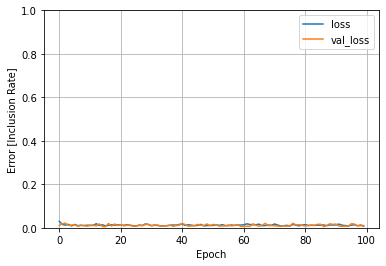

In [27]:
plot_loss(history)

In [28]:
linear_model_underfit.evaluate(test_data_underfit, test_labels)

14/14 [==============================] - 0s 1ms/step - loss: 0.0069


0.0069464691914618015

This simple model is a lot more accurate, but also less interesting. We need to figure out which of the complex features we want to continue to use. Let's get counts for each of our features so we can exclude any that might apply to only a few cards since those cases are most likely to lead to overfitting. For now let's exclude any features that are present fewer than 10 times. This leaves us with 58 features.

In [29]:
counts = dummyDf.sum(axis=0)
slightlySmallerDF = dummyDf.drop(counts[counts < 10.0].index, axis=1)
slightlySmallerDF.columns

Index(['cost', 'attack', 'health', 'Inclusion Rate', 'Adapt', 'Aura',
       'Battlecry', 'Charge', 'Colossal +X', 'Combo', 'Deathrattle',
       'Discover', 'Divine Shield', 'Dormant', 'Dredge', 'Freeze', 'Frenzy',
       'Honorable Kill', 'Inspire', 'Lifesteal', 'Magnetic', 'Outcast',
       'Overload', 'Poisonous', 'Reborn', 'Rush', 'Secret', 'Silence',
       'Spell Damage', 'Spellburst', 'Stealth', 'Taunt', 'Windfury',
       'rarity_Common', 'rarity_Epic', 'rarity_Legendary', 'rarity_Rare',
       'playerClass_Demon Hunter', 'playerClass_Druid', 'playerClass_Hunter',
       'playerClass_Mage', 'playerClass_Neutral', 'playerClass_Paladin',
       'playerClass_Priest', 'playerClass_Rogue', 'playerClass_Shaman',
       'playerClass_Warlock', 'playerClass_Warrior', 'race_Beast',
       'race_Demon', 'race_Dragon', 'race_Elemental', 'race_Mech',
       'race_Murloc', 'race_Naga', 'race_Pirate', 'race_Quilboar',
       'race_Totem'],
      dtype='object')

In [30]:
s_train_data = slightlySmallerDF.sample(frac=0.8, random_state=0)
s_test_data = slightlySmallerDF.drop(s_train_data.index)

s_train_labels = s_train_data.pop('Inclusion Rate')
s_test_labels = s_test_data.pop('Inclusion Rate')

In [31]:
s_normalizer = tf.keras.layers.Normalization(axis=-1)
s_normalizer.adapt(np.array(s_train_data))

In [32]:
s_linear_model = tf.keras.Sequential([
    s_normalizer,
    layers.Dense(units=1)
])

s_linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_absolute_error')

In [33]:
%%time
s_history = s_linear_model.fit(
    s_train_data,
    s_train_labels,
    epochs=50,
    verbose=0,
    validation_split = 0.2)

CPU times: user 11.4 s, sys: 3.96 s, total: 15.3 s
Wall time: 7.46 s


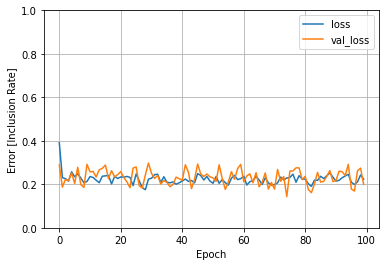

In [34]:
def plot_loss(s_history):
  plt.plot(s_history.history['loss'], label='loss')
  plt.plot(s_history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Inclusion Rate]')
  plt.legend()
  plt.grid(True)

plot_loss(s_history)

In [35]:
s_linear_model.evaluate(s_test_data, s_test_labels)

14/14 [==============================] - 0s 1ms/step - loss: 0.2169


0.21685363352298737

This model does much better than our model with all the features, but still significantly worse than a model that uses only the most baisic features. Before we do any more feature engineering let's experiment with adding a hidden layer. Lets start by adding a hidden layer to our simple model.

In [49]:
train_data_underfit = train_data[['cost', 'attack', 'health']]
test_data_underfit = test_data[['cost', 'attack', 'health']]

normalizer_underfit = tf.keras.layers.Normalization(axis=-1)
normalizer_underfit.adapt(np.array(train_data_underfit))

linear_model_underfit = tf.keras.Sequential([
    normalizer_underfit,
    layers.Dense(units=2),
    layers.Dense(units=1)
])

linear_model_underfit.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_absolute_error')

CPU times: user 6.71 s, sys: 1.94 s, total: 8.66 s
Wall time: 4.13 s


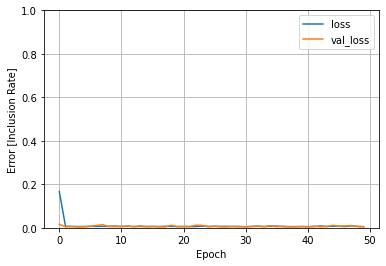

In [50]:
%%time
history = linear_model_underfit.fit(
    train_data_underfit,
    train_labels,
    epochs=50,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

plot_loss(history)

In [51]:
linear_model_underfit.evaluate(test_data_underfit, test_labels)

14/14 [==============================] - 0s 1ms/step - loss: 0.0060


0.0060196821577847

This model performs only slightly better than the same model with no hidden layer. This makes sense since this model is super simple. Our model with more features might benifit more from adding hidden layers. Lets start by adding one hidden layer.

In [73]:
s_train_data = slightlySmallerDF.sample(frac=0.8, random_state=0)
s_test_data = slightlySmallerDF.drop(s_train_data.index)

s_train_labels = s_train_data.pop('Inclusion Rate')
s_test_labels = s_test_data.pop('Inclusion Rate')

s_linear_model = tf.keras.Sequential([
    s_normalizer,
    layers.Dense(units=2),
    layers.Dense(units=1)
])

s_linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_absolute_error')

CPU times: user 6.61 s, sys: 2.84 s, total: 9.45 s
Wall time: 4.32 s


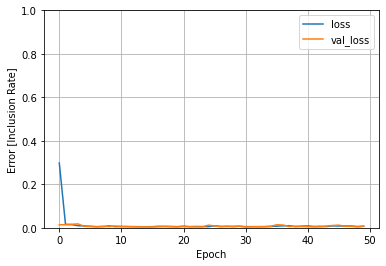

In [74]:
%%time
s_history = s_linear_model.fit(
    s_train_data,
    s_train_labels,
    epochs=50,
    verbose=0,
    validation_split = 0.2)

plot_loss(s_history)

In [75]:
s_linear_model.evaluate(s_test_data, s_test_labels)

14/14 [==============================] - 0s 1ms/step - loss: 0.0083


0.008287100121378899

After experimenting with different numbers of nodes it seeme like having two on the first hidden layer led to the best performance. This model is approaching the performance of our oversimplified model. Now we can try adding more layers to see if we can do even better.

In [104]:
s_train_data = slightlySmallerDF.sample(frac=0.8, random_state=0)
s_test_data = slightlySmallerDF.drop(s_train_data.index)

s_train_labels = s_train_data.pop('Inclusion Rate')
s_test_labels = s_test_data.pop('Inclusion Rate')

s_linear_model = tf.keras.Sequential([
    s_normalizer,
    layers.Dense(units=10),
    layers.Dense(units=2),
    layers.Dense(units=1)
])

s_linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_absolute_error')

CPU times: user 7.77 s, sys: 2.82 s, total: 10.6 s
Wall time: 4.76 s


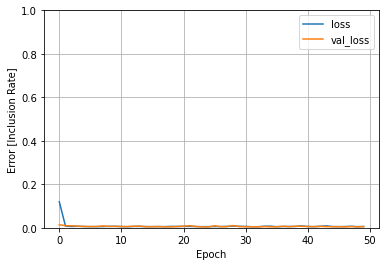

In [105]:
%%time
s_history = s_linear_model.fit(
    s_train_data,
    s_train_labels,
    epochs=50,
    verbose=0,
    validation_split = 0.2)

plot_loss(s_history)

In [106]:
s_linear_model.evaluate(s_test_data, s_test_labels)

14/14 [==============================] - 0s 2ms/step - loss: 0.0058


0.00583212124183774

Let's try adding another layer and see if that improves our performance.

In [122]:
s_train_data = slightlySmallerDF.sample(frac=0.8, random_state=0)
s_test_data = slightlySmallerDF.drop(s_train_data.index)

s_train_labels = s_train_data.pop('Inclusion Rate')
s_test_labels = s_test_data.pop('Inclusion Rate')

s_linear_model = tf.keras.Sequential([
    s_normalizer,
    layers.Dense(units=15),
    layers.Dense(units=10),
    layers.Dense(units=2),
    layers.Dense(units=1)
])

s_linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    loss='mean_absolute_error')

CPU times: user 7.79 s, sys: 3.14 s, total: 10.9 s
Wall time: 4.77 s


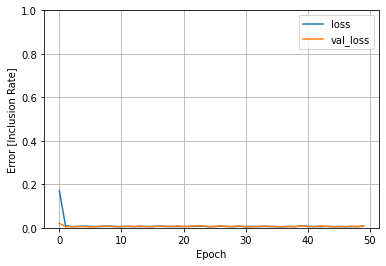

In [123]:
%%time
s_history = s_linear_model.fit(
    s_train_data,
    s_train_labels,
    epochs=50,
    verbose=0,
    validation_split = 0.2)

plot_loss(s_history)

In [124]:
s_linear_model.evaluate(s_test_data, s_test_labels)

14/14 [==============================] - 0s 1ms/step - loss: 0.0083


0.008282316848635674

Adding a third hidden layer doesn't seem to make any noticeable improvements, so let's stick with two layers. I plan to extend this project by systematically evaluating different configurations of this network.